In [1]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [2]:
####
####

### Select Regime from "kerr_qubit", "kerr_bistable", "intermediate_state"
### TODO: implement a regime "transition_kerr" which increases the drive periodically, or stochastically, etc.

Regime = "kerr_qubit"
file_name = './trajectory_data/QSD_' + Regime

####

### Which file formats to save trajectory data.
### Name of the file to save. The extension will be .mat for matlab and .pkl for pickle.

## matlab file.
save_mat = True

## pkl file (can be loaded in python) in the same format as above.
save_pkl = True

####
####

In [3]:
import matplotlib as mil
mil.use('TkAgg')

In [4]:
## QHDL package
from qnet.algebra.circuit_algebra import *
from qnet.circuit_components.displace_cc import Displace
from sympy import sqrt

## quantum state diffusion solver
from quantum_state_diffusion import qsd_solve

## numerical libraries
import numpy as np
import numpy.linalg as la
from scipy import sparse

## SDE integrator
import sdeint

## plottinsg
import matplotlib.pyplot as plt

## pickle
import pickle

In [5]:
from save2matfile_or_pkl import save2matfile_or_pkl

In [6]:
%matplotlib inline

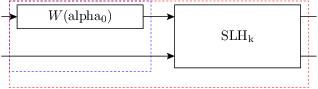

In [20]:
# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

if Regime == "kerr_bistable":
    ## bistable regime
    params = {alpha0 : 52.467, chi : -106.066, Delta : 750., kappa_1 : 150., kappa_2 : 0,
              'Ntraj' : 1, 'duration' : 2500., 'Nfock' : 15}
elif Regime == "kerr_qubit":
    ## qubit regime
    params = {alpha0 : 10.0, chi : -100, Delta : 0., kappa_1 : 0.5, kappa_2 : 0,
              'Ntraj' : 10, 'duration' : 5000., 'Nfock' : 15, 'delta_t': 2e-5, 'downsample': 100}
elif Regime == "intermediate_state":
    params = {alpha0 : 100.0, chi : -20.0, Delta : 0, kappa_1 : 1., kappa_2 : 0,
              'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}
else:
    raise ValueError("Unknown regime, or not implemented yet.")
    
## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']
delta_t = params['delta_t']
downsample = params['downsample']

# Construct Kerr SLH
a_k = Destroy("k")
S = -identity_matrix(2)
L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
H = Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k
KERR = SLH(S, L, H).toSLH()

# Add coherent drive
SYS = KERR << Displace(alpha=alpha0)+cid(1)
SYS.show()
SYS = SYS.toSLH()

SYS_num = SYS.substitute(params)

SYS_num.space.dimension = Nfock
tspan = np.arange(0, duration*1e-3, delta_t)

H_num, L_num = SYS_num.HL_to_qutip()

## Observables

obs = [a_k.dag()*a_k, a_k+a_k.dag(), (a_k-a_k.dag())/1j]
obsq = [o.to_qutip(full_space = SYS_num.space) for o in obs]

In [21]:
psi0 = sparse.csr_matrix(([1] + [0]*(Nfock-1)),dtype=np.complex128).T
H = H_num.data
Ls = [L.data for L in L_num]
obsq = [ob.data for ob in obsq]

In [22]:
ntraj = params["Ntraj"]

In [23]:
seed = [i for i in range(ntraj)]

In [24]:
D = qsd_solve(H, psi0, tspan, Ls, sdeint.itoSRI2, obsq = obsq, ntraj = ntraj, seed = seed, normalize_state = True)

Run time:   794.5016860961914  seconds.


In [25]:
D.update({'tspan':tspan})

In [26]:
D_downsampled = {'psis' : D['psis'][:,::downsample],
                 'obsq_expects' : D['obsq_expects'][:,::downsample], 
                 'seeds' : D['seeds'],
                 'tspan' : D['tspan'] }

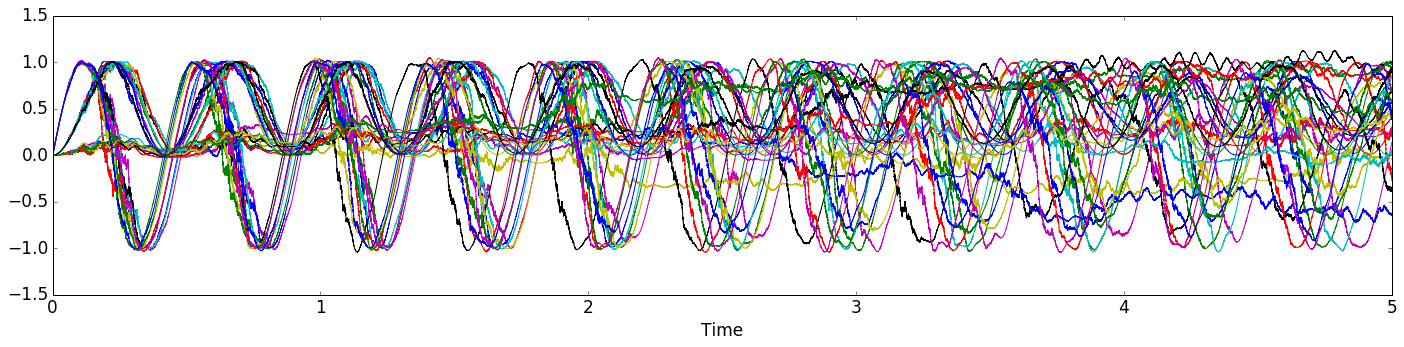

In [27]:
## Plot the observables
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(ntraj):
    for i in range(3):
        plt.plot(tspan,D['obsq_expects'][t,:,i].real)

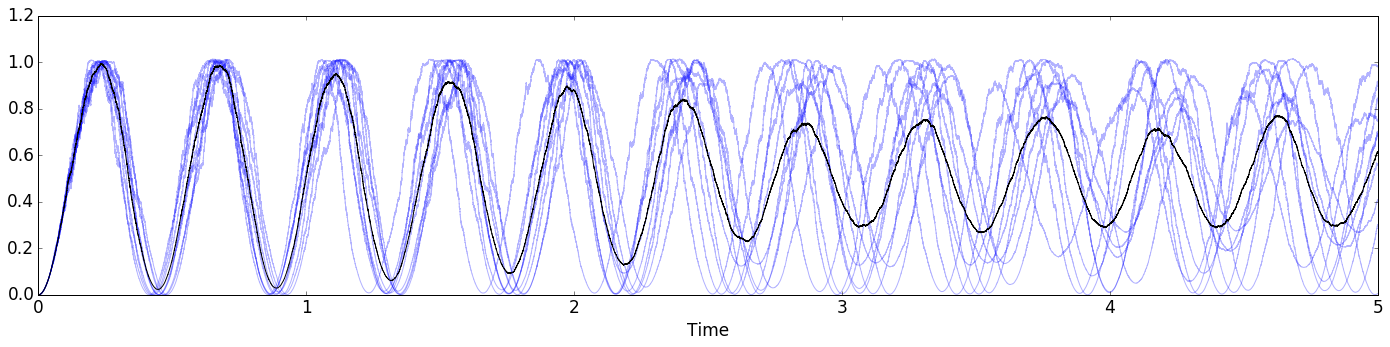

In [28]:
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for t in range(ntraj): 
    a.plot( tspan, D['obsq_expects'][t,:,0].real , "b", alpha=0.3)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )


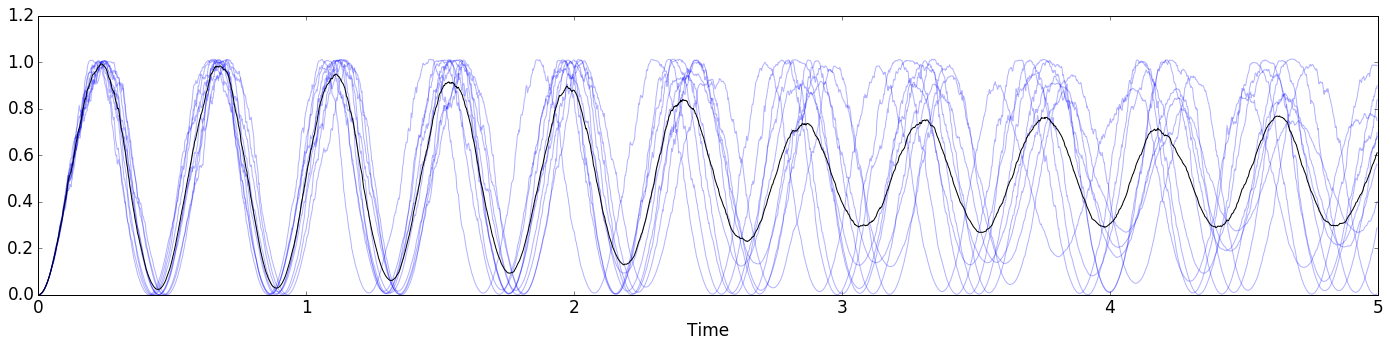

In [29]:
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for t in range(ntraj): 
    a.plot( tspan[::downsample],
           D['obsq_expects'][t,::downsample,0].real , "b", alpha=0.3)

a.plot(tspan[::downsample],
       np.average( np.asarray( [D['obsq_expects'][t,::downsample,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )


In [30]:
## Save downsampled QSD trajectories below

In [32]:
save2matfile_or_pkl(D_downsampled, file_name, obs, params = {}, save_mat = save_mat, save_pkl = save_pkl)

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_kerr_qubit.mat

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_kerr_qubit.pkl

{'expects': array([[[  0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j],
         [  1.99899976e-04 +1.15912692e-69j,
            2.82771850e-02 -1.41512554e-51j,
           -1.11239977e-07 -1.73472348e-18j],
         [  7.99212516e-04 -3.03858168e-64j,
            5.65402946e-02 -6.73637541e-46j,
            5.57620193e-06 +3.46944695e-18j],
         ..., 
         [  6.70884246e-01 +0.00000000e+00j,
            9.59213457e-01 +1.58666678e-33j,
            2.22079685e-01 -5.55111512e-17j],
         [  6.68432031e-01 +9.57918872e-48j,
            9.62236809e-01 +1.26842371e-33j,
            2.26504449e-01 +2.61253044e-33j],
         [  6.98358536e-01 +0.00000000e+00j,
            9.42986197e-01 -5.55111512e-17j,
            2.55157961e-01 -5.02926043e-33j]],
 
        [[  0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j],
         [  1.99899